# Sentiment Classifier using feed-forward Neural Networks - TF-IDF features

The goal of this notebook is to develop a sentiment classifier using feed-forward neural networks for the Twitter sentiment analysis dataset. We are going to experiment and develop a model which uses TD-IDF features, and evaluate it using known metrics such as F1 score, Recall and Precision. 

We are going to expirement with parameters like:
 - Number of hidden layers
 - Activation functions
 - The loss function
 - The optimizer

 The data is going to be preprocessed and scaled, in order to maximize our classifier's potential.

 The classifier is going to be implemented using the PyTorch API.

## Import Libraries

In [1]:
!python -m textblob.download_corpora
# For NN models
import torch.nn as nn
import torch
# For data vizualization 
import matplotlib as mpl
import matplotlib.pyplot as plt
# For large and multi-dimensional arrays
import numpy as np
# For basic cleaning and data preprocessing 
import re
# For data manipulation and analysis
import pandas as pd
# Stop words
import nltk 
nltk.download('stopwords')  
#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import scipy
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
# Necessary for data format
from sklearn.feature_extraction.text import CountVectorizer
# Word embedings
from sklearn.feature_extraction.text import TfidfVectorizer  
# Machine learning model
from sklearn.linear_model import LogisticRegression
# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import precision_recall_fscore_support 
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
# Best parameters during classification
from sklearn.model_selection import GridSearchCV
# Data preprocessing
from sklearn.model_selection import train_test_split
# Validation of the model
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate


[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Unzipping corpora/conll2000.zip.
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.
Finished.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Dataset Configuration

We are going to import the dataset...

In [2]:
df = pd.read_csv("/content/drive/MyDrive/tn2/SentimentTweets.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1280000 entries, 0 to 1279999
Data columns (total 7 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   Unnamed: 0  1280000 non-null  int64 
 1   target      1280000 non-null  int64 
 2   id          1280000 non-null  int64 
 3   date        1280000 non-null  object
 4   flag        1280000 non-null  object
 5   user        1280000 non-null  object
 6   text        1280000 non-null  object
dtypes: int64(3), object(4)
memory usage: 68.4+ MB


...and take a look at its columns

In [3]:
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,#brokenpromises...
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,David Carradine so sad. Thai's law not sure i...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,A @ 415 B @ 425. Tell your bro i say congrats!
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,@littlefluffycat Indeed.
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,Completed Race 4 Life in 58mins with girlies f...


Also, because the tweets are more than a million, we are going to keep 10% of them, to avoid overfitting, and to relief our RAM!

In [4]:
df = df[:200000]

## Data Preprocessing

Like always, we have to preprocess our data set. We are going to convert everything to lowercase, and remove any punctuation points, weird characters and links.


We are going to classify tweets. As we all know, twitter users use the symbols `#` and `@` a lot. This may cause problem to the classifier, thus we are going to remove them, using `TextBlob`. We are also going to lemmatize the data in order to avoid multiple representations of the same word

In [5]:
def text_normalization(text):
    # convert text to lowercase
    text = text.lower()
    # remove non alphanumeric character
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text)
    # remove links
    text = re.sub(r'https?:/\/\S+', ' ', text)
    # apply blob techniques
    tweet_blob = TextBlob(text)
    # return normalized text
    blob_res = ' '.join(tweet_blob.words)
    # lematization techniques
    lemmatizer = WordNetLemmatizer() 
    # stop words definition
    stop_words = nltk.corpus.stopwords.words('english')
    # combine all previous methods in order to clear the text
    result = ' '.join(
        lemmatizer.lemmatize(term) 
        for term in text.split()
        if term not in set(stop_words)
    )
    return result

In [6]:
def preprocess(input_df):
    # Remove rows with missing values in column col
    input_df.dropna(inplace=True)
    # Speed up code using numpy vectorization
    vfunc = np.vectorize(text_normalization)
    input_df.text = vfunc(input_df.text.values)
    # return processed input_df
    return input_df

Let's now apply those techniques in our dataset.

In [7]:
df = preprocess(df)
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,brokenpromises
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,david carradine sad thai law sure fowl play ma...
2,1337108,4,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,415 b 425 tell bro say congrats
3,1560887,4,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,littlefluffycat indeed
4,1466295,4,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,completed race 4 life 58mins girlies work fun ...


We are going to convert the target value to 1 instead of 4, in order to be more convenient.

In [8]:
def change_to_1(x):
    if (x == 4):
        return 1
    else:
        return x

In [9]:
df['target'] = df['target'].apply(change_to_1)
df.head()

,Unnamed: 0,target,id,date,flag,user,text
0,680949,0,2249621587,Fri Jun 19 22:41:08 PDT 2009,NO_QUERY,sukumarpant,brokenpromises
1,406741,0,2059003515,Sat Jun 06 16:03:21 PDT 2009,NO_QUERY,MTMSparrow,david carradine sad thai law sure fowl play ma...
2,1337108,1,2017466467,Wed Jun 03 08:26:14 PDT 2009,NO_QUERY,itsmemcee,415 b 425 tell bro say congrats
3,1560887,1,2186457254,Mon Jun 15 18:52:04 PDT 2009,NO_QUERY,jdfreivald,littlefluffycat indeed
4,1466295,1,2064458395,Sun Jun 07 06:19:20 PDT 2009,NO_QUERY,CrazyHan,completed race 4 life 58mins girlies work fun ...


## Spiltting the Dataset

In order to train our model, we are going to use a significant portion of the dataset, but we also need some data to test our classifier, thus we are going to split the dataset into 2 datasets: one for training, and one for testing.

First, we are going to define which are our X and Y variables

In [10]:
X = df['text']
Y = df['target']

Then, split the datasets by keeping 80% for training and 20% for testing.

In [11]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2)

 ## Feature extraction: TF-IDF

Next up, we are going to transform our data to a feature vector. In order to do that, we're gonna use TfidfVectorizer.

Because of the large amount of tweets, and thus the large amount of words, we are going to limit our vocabulary, in order to not create an erormus vector. We opt to store the vectors that occur more often in the tweets, in order to save space, while not compromising our accuracy. We are going words that occur on more than `0.5%` of the tweets, and on less than `70%` of the tweets.

In [12]:
tfidf_vec = TfidfVectorizer(max_df=0.7, min_df=0.005)  

In [13]:
tfidf_train_vec = tfidf_vec.fit_transform(X_train)
tfidf_test_vec = tfidf_vec.transform(X_test)

tfidf_train_data = pd.DataFrame(tfidf_train_vec.toarray())
tfidf_test_data = pd.DataFrame(tfidf_test_vec.toarray())
tfidf_train_data.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.316552,0.0,0.3894,0.000000,0.451302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.403635,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.545071,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.402400,0.0,0.0000,0.587151,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.48571,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.476196,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert to Tensors

We are going to use the PyTorch API, thus we must convert all of our feature vectors to tensors, by first transforming them to numpy arrays

In [14]:
train_x = tfidf_train_data.to_numpy()
test_x = tfidf_test_data.to_numpy()

X_train_tensor = torch.as_tensor(train_x, dtype=torch.float32)
Y_train_tensor = torch.as_tensor(Y_train.values, dtype=torch.float32)

X_test_tensor = torch.as_tensor(test_x, dtype=torch.float32)
Y_test_tensor = torch.as_tensor(Y_test.values, dtype=torch.float32)


Y_train_tensor = Y_train_tensor.view(Y_train_tensor.size()[0], 1)
Y_test_tensor = Y_test_tensor.view(Y_test_tensor.size()[0], 1)

## First Model

For our first model we are going to use a simple neural network consisting of 1 fully connected layer. 

We are going to do so by extending the extending the `nn.Module` class. This requires us to create an `__init__` and a `forward` method.

### Define the Model

In [15]:
class Model_1(nn.Module):
  def __init__(self, input_size, hidden_neurons_first):
    super(Model_1, self).__init__()

    # 1st linear function: vocab_size -> hidden_neurons
    self.layer_1 = nn.Linear(input_size, hidden_neurons_first)
    # activation function for 1st layer
    self.relu_1 = nn.ReLU()

    # output layer: hidden_neurons -> 1 neuron (classification)
    self.output = nn.Linear(hidden_neurons_first, 1)
    # activation using the sigmoid function
    self.activation = nn.Sigmoid()

  def forward(self, x):
    out = self.layer_1(x)
    out = self.relu_1(out)

    out = self.output(out)
    out = self.activation(out)

    return out

### Training the Model

Next up, we are going to define the appropriate functions that use the previosly mentioned class in order to train our model.

#### Define the training process

Code for training one epoch, which involves the learning procedure that we've learned from theory

In [16]:
def train_epoch(optimizer, model, train_data, train_labels):
  # clear gradients
  optimizer.zero_grad()
  outputs = model.forward(train_data)
  predict_Y = outputs.detach().numpy().round()
  real_Y = train_labels.numpy()
  # compute loss w.r.t batch
  loss = torch.nn.BCELoss()(outputs, train_labels)
  # pass gradients back, startiing on loss value
  loss.backward()
  # update parameters
  optimizer.step()
  metrics_list = precision_recall_fscore_support(predict_Y, real_Y, average='macro')
  # return the total to keep track of how you did this time around
  return loss, metrics_list[0], metrics_list[1], metrics_list[2]

#### Hyperparameters definition

Definition of our hyperparameters. Lots of different values were tried as I experemented with thoser parameters, in order to achieve the best results of the model

In [17]:
epochs = 100
learning_rate = 0.01
hidden_neurons_first = 200
input_size = X_train_tensor.size()[1]
model = Model_1(input_size, hidden_neurons_first)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

#### Training procedure

The training procedure is simple: We train for every epoch that the user requested, and store the loss in order to plot it

In [18]:
loss = []

for epoch in range(epochs):
  epoch_loss, precision, recall, f1_score = train_epoch(optimizer, model, X_train_tensor, Y_train_tensor)
  if (epoch % 5 == 0 or epoch == epochs -1):
    print("Epoch: ", epoch, " loss: ", round(epoch_loss.item(),4), " precision: ", round(precision, 4), " recall: ", round(recall, 4), " f1_score ", round(f1_score, 4))
  loss.append(epoch_loss.item())

Epoch:  0  loss:  0.6935  precision:  0.5  recall:  0.4156  f1_score  0.3324
Epoch:  5  loss:  0.6307  precision:  0.6678  recall:  0.6744  f1_score  0.6649
Epoch:  10  loss:  0.5858  precision:  0.6825  recall:  0.6831  f1_score  0.6824
Epoch:  15  loss:  0.5773  precision:  0.6865  recall:  0.6904  f1_score  0.685
Epoch:  20  loss:  0.5723  precision:  0.6891  recall:  0.6912  f1_score  0.6884
Epoch:  25  loss:  0.5699  precision:  0.6889  recall:  0.6903  f1_score  0.6885
Epoch:  30  loss:  0.5676  precision:  0.6903  recall:  0.6927  f1_score  0.6895
Epoch:  35  loss:  0.5661  precision:  0.6912  recall:  0.6937  f1_score  0.6903
Epoch:  40  loss:  0.5642  precision:  0.6922  recall:  0.6944  f1_score  0.6915
Epoch:  45  loss:  0.5623  precision:  0.6937  recall:  0.6959  f1_score  0.6929
Epoch:  50  loss:  0.5602  precision:  0.6959  recall:  0.6983  f1_score  0.6951
Epoch:  55  loss:  0.5578  precision:  0.6979  recall:  0.7  f1_score  0.6973
Epoch:  60  loss:  0.5552  precision:

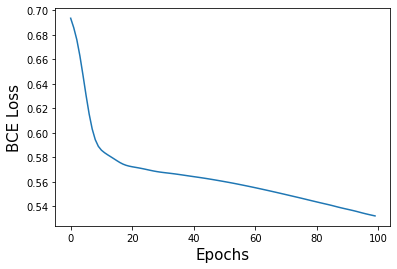

In [19]:
plt.plot(loss)
plt.xlabel("Epochs", fontsize=15)
plt.ylabel("BCE Loss", fontsize=15)
plt.show()

### Predict

In order to predict our test set, we just apply the forwaring procedure with the weights that we have learned. The result will be a float number between 0 and 1, which is the probability of the item belonging to the positive class. Thus, in order to gather the predicted labels, we will round the number, as probabilities near 0 must be classified as negative, and near 1, must be classified as positive

In [20]:
predict_outs = model.forward(X_test_tensor)
predict_Y = predict_outs.detach().numpy().round()
test_Y = Y_test_tensor.numpy()

In order to check our results, we will print the accuracy of our model, as well as a full classification report for both of our classes

In [21]:
print("Accuracy score: {}".format(round(accuracy_score(test_Y,predict_Y),3)))
print(classification_report(test_Y,predict_Y))

Accuracy score: 0.691
              precision    recall  f1-score   support

         0.0       0.72      0.62      0.67     19951
         1.0       0.67      0.76      0.71     20049

    accuracy                           0.69     40000
   macro avg       0.69      0.69      0.69     40000
weighted avg       0.69      0.69      0.69     40000



### ROC Curves

A usefull and handy way to observe how our binary classification model behaves are ROC curves. It is a plot of the false positive rate (x-axis) versus the true positive rate (y-axis) for a number of different candidate threshold values between 0.0 and 1.0.

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.770


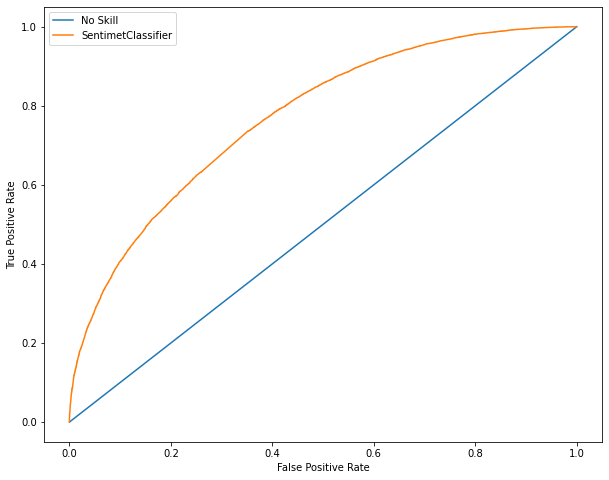

In [22]:
# calculate the fpr and tpr for all thresholds of the classification
probs = predict_outs.detach().numpy()

# # keep probabilities for the positive outcome only
lr_probs = probs
ns_probs = [0 for _ in range(len(test_Y))]

# calculate scores
ns_auc = roc_auc_score(test_Y, ns_probs)
lr_auc = roc_auc_score(test_Y, lr_probs)

# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(test_Y, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(test_Y, lr_probs)

# plot the roc curve for the model
plt.figure(figsize=(10,8))
plt.plot(ns_fpr, ns_tpr, label='No Skill')
plt.plot(lr_fpr, lr_tpr, label='SentimetClassifier')

# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()